In [28]:
import Pkg; 

if split(pwd(),"/")[end] == "prototyping"
    cd(joinpath(@__DIR__, "../../"))
    Pkg.activate("Project.toml")
end

using MorphoMolNotebooks
using MorphoMol
using PyCall
using JLD2
using LinearAlgebra 
using NearestNeighbors
using Rotations
using GeometryBasics
using GLMakie
using Random
using Distances

In [163]:
function get_multichromatic_tetrahedra(points, n_atoms_per_mol)
    py"""
    import numpy as np
    import diode

    def get_multichromatic_tetrahedra(points, n_atoms_per_mol):        
        def is_multi(sigma):
            return len(set(v // n_atoms_per_mol for v in sigma)) >= 2
        points = np.asarray(points)
        tetrahedra = [vs for (vs,fs) in diode.fill_alpha_shapes(points) if len(vs) == 4 and is_multi(vs)]
        return tetrahedra
    """
    py"get_multichromatic_tetrahedra"(points, n_atoms_per_mol)
end

function get_barycentric_subdivision_and_filtration(points, mc_tets)
    barycenters = Vector{Point3f}([])
    filtration = Vector{Tuple{Vector{Int}, Float64}}([])
    total_vertices = 0
    for vs in eachrow(mc_tets)
        part_one = [v+1 for v in vs if div(v, 1206)==0]
        part_two = [v+1 for v in vs if div(v, 1206)==1]
        if length(part_one) == length(part_two) 
            #Get Simplices and Values for even split
            x,y = part_one[1], part_one[2]
            u,v = part_two[1], part_two[2]
            barycenters = [barycenters; [
                get_barycenter(points, [x,y,u,v]),  #1
                get_barycenter(points, [x,v]),      #2
                get_barycenter(points, [x,y,v]),    #3
                get_barycenter(points, [y,v]),      #4
                get_barycenter(points, [y,u,v]),    #5
                get_barycenter(points, [y,u]),      #6
                get_barycenter(points, [x,y,u]),    #7
                get_barycenter(points, [x,u]),      #8
                get_barycenter(points, [x,u,v]),    #9
            ]]
            vertices = [
                ([1] .+ total_vertices, euclidean(get_barycenter(points, [x,y]), get_barycenter(points, [u,v])) / 2.0), 
                ([2] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [v])) / 2.0),
                ([3] .+ total_vertices, euclidean(get_barycenter(points, [x,y]), get_barycenter(points, [v])) / 2.0),
                ([4] .+ total_vertices, euclidean(get_barycenter(points, [y]), get_barycenter(points, [v])) / 2.0),
                ([5] .+ total_vertices, euclidean(get_barycenter(points, [y]), get_barycenter(points, [u, v])) / 2.0),
                ([6] .+ total_vertices, euclidean(get_barycenter(points, [y]), get_barycenter(points, [u])) / 2.0),
                ([7] .+ total_vertices, euclidean(get_barycenter(points, [x,y]), get_barycenter(points, [u])) / 2.0),
                ([8] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [u])) / 2.0),
                ([9] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [v,u])) / 2.0),
            ]
            edges = [
                ([1,2] .+ total_vertices, minimum([vertices[1][2], vertices[2][2]])),
                ([1,3] .+ total_vertices, minimum([vertices[1][2], vertices[3][2]])),
                ([1,4] .+ total_vertices, minimum([vertices[1][2], vertices[4][2]])),
                ([1,5] .+ total_vertices, minimum([vertices[1][2], vertices[5][2]])),
                ([1,6] .+ total_vertices, minimum([vertices[1][2], vertices[6][2]])),
                ([1,7] .+ total_vertices, minimum([vertices[1][2], vertices[7][2]])),
                ([1,8] .+ total_vertices, minimum([vertices[1][2], vertices[8][2]])),
                ([1,9] .+ total_vertices, minimum([vertices[1][2], vertices[9][2]])),
                ([2,3] .+ total_vertices, minimum([vertices[2][2], vertices[3][2]])),
                ([3,4] .+ total_vertices, minimum([vertices[3][2], vertices[4][2]])),
                ([4,5] .+ total_vertices, minimum([vertices[4][2], vertices[5][2]])),
                ([5,6] .+ total_vertices, minimum([vertices[5][2], vertices[6][2]])),
                ([6,7] .+ total_vertices, minimum([vertices[6][2], vertices[7][2]])),
                ([7,8] .+ total_vertices, minimum([vertices[7][2], vertices[8][2]])),
                ([8,9] .+ total_vertices, minimum([vertices[8][2], vertices[9][2]])),
                ([9,2] .+ total_vertices, minimum([vertices[9][2], vertices[2][2]]))
            ]
            triangles = [
                ([1,2,3] .+ total_vertices, minimum([vertices[1][2], vertices[2][2], vertices[3][2]])),
                ([1,3,4] .+ total_vertices, minimum([vertices[1][2], vertices[3][2], vertices[4][2]])),
                ([1,4,5] .+ total_vertices, minimum([vertices[1][2], vertices[4][2], vertices[5][2]])),
                ([1,5,6] .+ total_vertices, minimum([vertices[1][2], vertices[5][2], vertices[6][2]])),
                ([1,6,7] .+ total_vertices, minimum([vertices[1][2], vertices[6][2], vertices[7][2]])),
                ([1,7,8] .+ total_vertices, minimum([vertices[1][2], vertices[7][2], vertices[8][2]])),
                ([1,8,9] .+ total_vertices, minimum([vertices[1][2], vertices[8][2], vertices[9][2]])),
                ([1,9,2] .+ total_vertices, minimum([vertices[1][2], vertices[9][2], vertices[2][2]]))
            ]
            total_vertices += 9
            filtration = [filtration; vertices; edges; triangles]
        end
        if length(part_one) != length(part_two)
            if length(part_one) < length(part_two)
                part_one, part_two = part_two, part_one
            end
            u,v,w = part_one[1], part_one[2], part_one[3]
            x = part_two[1]

            barycenters = [barycenters; [
                get_barycenter(points, [u,v,w,x]),  #1
                get_barycenter(points, [x,v]),      #2
                get_barycenter(points, [x,v,w]),    #3
                get_barycenter(points, [x,w]),      #4
                get_barycenter(points, [w,u,x]),    #5
                get_barycenter(points, [u,x]),      #6
                get_barycenter(points, [u,v,x]),    #7
            ]]
            vertices = [
                ([1] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [u,v,w])) / 2.0), 
                ([2] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [v])) / 2.0),
                ([3] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [v,w])) / 2.0),
                ([4] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [w])) / 2.0),
                ([5] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [w,u])) / 2.0),
                ([6] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [u])) / 2.0),
                ([7] .+ total_vertices, euclidean(get_barycenter(points, [x]), get_barycenter(points, [u,v])) / 2.0),
            ]
            edges = [
                ([1,2] .+ total_vertices, minimum([vertices[1][2], vertices[2][2]])),
                ([1,3] .+ total_vertices, minimum([vertices[1][2], vertices[3][2]])),
                ([1,4] .+ total_vertices, minimum([vertices[1][2], vertices[4][2]])),
                ([1,5] .+ total_vertices, minimum([vertices[1][2], vertices[5][2]])),
                ([1,6] .+ total_vertices, minimum([vertices[1][2], vertices[6][2]])),
                ([1,7] .+ total_vertices, minimum([vertices[1][2], vertices[7][2]])),
                ([2,3] .+ total_vertices, minimum([vertices[2][2], vertices[3][2]])),
                ([3,4] .+ total_vertices, minimum([vertices[3][2], vertices[4][2]])),
                ([4,5] .+ total_vertices, minimum([vertices[4][2], vertices[5][2]])),
                ([5,6] .+ total_vertices, minimum([vertices[5][2], vertices[6][2]])),
                ([6,7] .+ total_vertices, minimum([vertices[6][2], vertices[7][2]])),
                ([7,2] .+ total_vertices, minimum([vertices[7][2], vertices[2][2]]))
            ]
            triangles = [
                ([1,2,3] .+ total_vertices, minimum([vertices[1][2], vertices[2][2], vertices[3][2]])),
                ([1,3,4] .+ total_vertices, minimum([vertices[1][2], vertices[3][2], vertices[4][2]])),
                ([1,4,5] .+ total_vertices, minimum([vertices[1][2], vertices[4][2], vertices[5][2]])),
                ([1,5,6] .+ total_vertices, minimum([vertices[1][2], vertices[5][2], vertices[6][2]])),
                ([1,6,7] .+ total_vertices, minimum([vertices[1][2], vertices[6][2], vertices[7][2]])),
                ([1,7,2] .+ total_vertices, minimum([vertices[1][2], vertices[7][2], vertices[2][2]]))
            ]
            total_vertices += 7
            filtration = [filtration; vertices; edges; triangles]
        end
    end
    barycenters, filtration
end

function calculate_persistence_diagram(upper_star_filtration)
    py"""
    import numpy as np
    import oineus as oin 
    def calculate_persistence_diagram(upper_star_filtration):
        fil = oin.Filtration_double([oin.Simplex_double([v-1 for v in s[0]], s[1]) for s in upper_star_filtration], True)
        dcmp = oin.Decomposition(fil, True)
        params = oin.ReductionParams()
        params.clearing_opt = False
        dcmp.reduce(params)
        dgm = dcmp.diagram(fil, include_inf_points=False)
        return dgm
    """
    py"calculate_persistence_diagram"(upper_star_filtration)
end

function get_interface_with_persistence(points, n_atoms_per_mol)
    mc_tets = get_multichromatic_tetrahedra(points, n_atoms_per_mol)
    barycenters, filtration = get_barycentric_subdivision_and_filtration(points, mc_tets)
    dgms = calculate_persistence_diagram(filtration)
    dgms = [dgms[i] for i in 1:2]
    barycenters, filtration, dgms
end

get_interface_with_persistence (generic function with 1 method)

In [89]:
function txt_to_points(input_file)
    [[parse(Float64, s) for s in split(p," ")] for p in readlines(input_file)[3:end]]
end

txt_to_points (generic function with 1 method)

In [157]:
points = txt_to_points("../../Data/paper2/measure_paths/txts/6r7m/1/1571.txt");

In [164]:
barycenters, filtration, dgms = get_interface_with_persistence(points, 1206)

(Point{3, Float32}[[112.33027, 57.34023, 69.00146], [112.03998, 57.40709, 68.76749], [112.074814, 57.056774, 69.04561], [111.70298, 56.887817, 68.67494], [112.167534, 57.322075, 68.73963], [112.17906, 57.80504, 68.30852], [112.392204, 57.668255, 68.80132], [109.232445, 77.24187, 65.07171], [110.055084, 77.31339, 64.586205], [109.35835, 77.078476, 64.82433]  …  [123.85899, 56.986183, 75.35549], [124.675804, 62.124096, 76.32994], [122.658325, 54.296665, 78.7249], [105.88382, 67.603485, 50.71654], [102.8359, 61.365524, 58.973503], [105.87535, 68.34947, 50.72835], [107.51653, 86.353264, 47.046455], [106.98077, 79.357346, 48.25801], [104.49402, 77.87733, 55.267994], [103.860344, 62.698853, 56.209377]], [([1], 1.0994315147399902), ([2], 1.2827742099761963), ([3], 1.1803356409072876), ([4], 1.1561861038208008), ([5], 1.0100507736206055), ([6], 1.1422593593597412), ([7], 1.1739016771316528), ([1, 2], 1.0994315147399902), ([1, 3], 1.0994315147399902), ([1, 4], 1.0994315147399902)  …  ([12367, 1

In [92]:
get_barycenter(points, vertices) = Point3f(sum(points[vertices]) / length(vertices))

get_barycenter (generic function with 1 method)

get_barycentric_subdivision_and_filtration (generic function with 1 method)

In [148]:
barycenters, filtration = get_barycentric_subdivision_and_filtration(points, mc_tets)

f = Figure(fontsize = 12)
i_sc = LScene(f[1,1])
fcs = [TriangleFace(e[1]) for e in filtration if length(e[1]) == 3]
colors = [e[2] for e in filtration if length(e[1]) == 1]
mesh!(i_sc, GeometryBasics.Mesh(barycenters, fcs), color = colors, colorrange = (sqrt(minimum(colors)), sqrt(maximum(colors))), colormap = :magma)
display(f)

GLMakie.Screen(...)

calculate_persistence_diagram (generic function with 1 method)

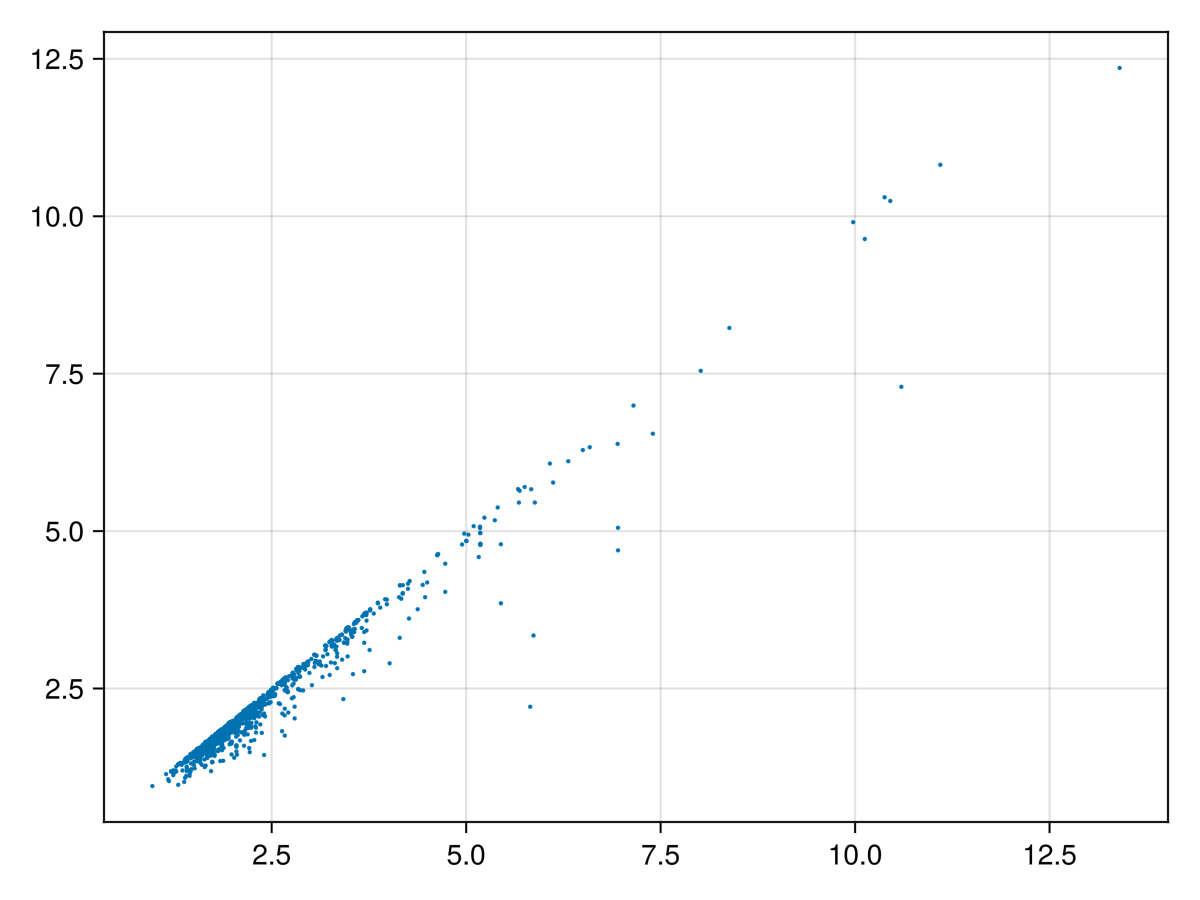

In [150]:
dgm = calculate_persistence_diagram(filtration)[1]
xs = dgm[:,1]
ys = dgm[:,2]
f = Figure()
ax = Axis(f[1,1])
scatter!(ax, xs, ys, markersize = 3)
f